# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [13]:
!python -m pip install pyyaml==5.1
!python -m pip install torch torchvision torchaudio
!python -m pip install opencv-python
!python -m pip install scikit-image
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 3.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached scipy-1.10.1-cp310-cp310-macosx_12_0_arm64.whl (28.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.0 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached PyWavelets-1.4.1-cp310-cp310-macosx_11_0_arm64.whl (4.3 MB)
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [21]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /Users/andrijapaurevic/miniforge3/envs/detectron2/lib/python3.10/site-packages/matplotlib/mpl-data
CONFIGDIR=/Users/andrijapaurevic/.matplotlib
interactive is False
platform is darwin
CACHEDIR=/Users/andrijapaurevic/.matplotlib
Using fontManager instance from /Users/andrijapaurevic/.matplotlib/fontlist-v330.json


# Train on a custom dataset

# QFLOW 

In [9]:
# Double check this directory! Should be ./QuantumDotControl/autotuning/coarse_tuning/models/detectron2
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/detectron2


In [10]:
# download
!wget https://data.nist.gov/od/ds/66492819760D3FF6E05324570681BA721894/data_qflow_lite.zip

# if this doesnt work, just go and download it and place it in ROOT_DIR

--2023-06-02 10:40:44--  https://data.nist.gov/od/ds/66492819760D3FF6E05324570681BA721894/data_qflow_lite.zip
Resolving data.nist.gov (data.nist.gov)... 18.235.227.114
Connecting to data.nist.gov (data.nist.gov)|18.235.227.114|:443... connected.
HTTP request sent, awaiting response... ^C


In [6]:
# Decompress data
!unzip data_qflow_lite.zip > ROOT_DIR

In [15]:
RAW_DATA_DIR = os.path.join(ROOT_DIR, "data_qflow_lite")
MODEL_DATA_DIR = os.path.join(ROOT_DIR, "csd")
MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
os.mkdir(MODEL_DATA_DIR)
os.mkdir(MODEL_TRAIN_DATA_DIR)
os.mkdir(MODEL_VAL_DATA_DIR)

In [36]:
import os 
import skimage as sk

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class ProcessData():
    def __init__(self):
        self.vgg_format = {}

    def extract_csd(self, path_to_data, isTrain):
        qflow_data = np.load(path_to_data, allow_pickle=True).item()

        voltages = {"P1": qflow_data['V_P1_vec'], "P2": qflow_data['V_P2_vec']}
        N = len(voltages["P1"])
        M = len(voltages["P2"])
        
        assert N == M

        self.width, self.height = N,M
        self.fileID = os.path.basename(path_to_data).replace(".npy","")
        self.filename = self.fileID+".jpg"

        # Extract current, state regimes and gradient
        I = np.array([
            data['current'] for data in qflow_data['output']
        ]).reshape((N,N))

        regimes = np.array([
            data['state'] for data in qflow_data['output']
        ]).reshape((N,N))

        def normalize(matrix):
            mean = matrix.mean()
            std = matrix.std()
            return (matrix - mean) / std

        I = normalize(I)

        SAVE_DIR = MODEL_TRAIN_DATA_DIR if isTrain else MODEL_VAL_DATA_DIR

        from PIL import Image
        im = Image.fromarray(I.astype(np.uint8))
        SAVE_PATH = os.path.join(SAVE_DIR, '{}.jpg'.format(self.fileID))
        im.save(SAVE_PATH)

        csd = {"I": np.array(I,dtype=np.float32), "regimes": regimes}

        return csd
    
    def vgg_annotate_csd(self,csd):

        # First create a list of objects in the image
        object_list = []

        regimes = csd["regimes"]

        labelled_regimes = sk.measure.label(
            regimes, background = -1, connectivity = 1
        )

        regions = sk.measure.regionprops(labelled_regimes)

        regions_list = []
        for index in range(1, labelled_regimes.max()):
                region_dict = {}
                vertices = regions[index].coords
                x,y = vertices.T

                regime = regimes[int(np.average(y)), int(np.average(x))]
                region_dict["shape_name"] = "polygon"
                region_dict["all_points_x"] = x.tolist()
                region_dict["all_points_y"] = y.tolist()

                if len(x.tolist()) <= 2 or len(y.tolist()) <=2:
                  print("Ignoring", self.filename, len(x.tolist()), len(y.tolist()), " because their polygons too small")
                  return -1
                region_dict["class"] = regime

                regions_list.append(region_dict)
        
        object = {}
        object["filename"] = self.filename
        object["size"] = self.width * self.height
        object["regions"] = regions_list

        object_list.append(object)

        # Now create the VGG format
        
        for object in object_list:
             
            filename = object["filename"]
            size = object["size"]
            regions = object["regions"]

            self.vgg_format[self.fileID] = {}
            self.vgg_format[self.fileID]["filename"] = filename
            self.vgg_format[self.fileID]["size"] = size
            self.vgg_format[self.fileID]["regions"] = {}

            index = 0

            for region in regions:
                region_dict = {}
                shape_attributes = {}

                shape_attributes["name"] = region["shape_name"]
                shape_attributes["all_points_x"] = region["all_points_x"]
                shape_attributes["all_points_y"] = region["all_points_y"]

                region_dict["shape_attributes"] = shape_attributes
                region_dict["region_attributes"] = {"label": region["class"]}

                self.vgg_format[self.fileID]["regions"][str(index)] = region_dict

                index += 1

        self.vgg_format[self.fileID]["file_attributes"] = {}
        return 0 

    def dump_json(self,train_val_split, dataset_size, save_folder):
            num_of_train = int(train_val_split * dataset_size)
            keys, values = zip(*self.vgg_format.items())
            vgg_format_train = dict(zip(keys[:num_of_train], values[:num_of_train]))
            vgg_format_val = dict(zip(keys[num_of_train:], values[num_of_train:]))

            with open(save_folder+"/train/via_region_data.json", "w") as f:
                json.dump(vgg_format_train, f, cls=NumpyEncoder)
            with open(save_folder+"/val/via_region_data.json", "w") as f:
                json.dump(vgg_format_val, f, cls=NumpyEncoder)


ProcessData = ProcessData()
datapath = RAW_DATA_DIR
save_dir = MODEL_DATA_DIR
dataset_size = 200
train_val_split = 0.9
counter = 0
dataset = []
for filename in os.listdir(datapath):
      if filename.endswith(".npy"):
        if counter == dataset_size: 
            break

        csd = ProcessData.extract_csd(os.path.join(datapath,filename), isTrain=True if counter < dataset_size * (train_val_split) else False)
        result = ProcessData.vgg_annotate_csd(csd)

        dataset.append(csd)

        counter += 1 + result


ProcessData.dump_json(train_val_split, dataset_size, save_dir)

Ignoring 20171118-124043491570.jpg 1 1  because their polygons too small
Ignoring 20171118-124645305488.jpg 1 1  because their polygons too small
Ignoring 20171118-133403683301.jpg 2 2  because their polygons too small
Ignoring 20171118-132211254586.jpg 1 1  because their polygons too small
Ignoring 20171118-130226680182.jpg 1 1  because their polygons too small
Ignoring 20171118-133058030715.jpg 1 1  because their polygons too small
Ignoring 20171118-133844691242.jpg 1 1  because their polygons too small
Ignoring 20171118-134048401828.jpg 1 1  because their polygons too small
Ignoring 20171118-133931371437.jpg 1 1  because their polygons too small
Ignoring 20171118-125346753976.jpg 1 1  because their polygons too small
Ignoring 20171118-124805021494.jpg 1 1  because their polygons too small
Ignoring 20171118-132021005170.jpg 1 1  because their polygons too small
Ignoring 20171118-124527127708.jpg 1 1  because their polygons too small
Ignoring 20171118-133915695830.jpg 1 1  because the

In [37]:
from detectron2.structures import BoxMode

def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = 100, 100
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x+ 0.5, y+0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": int(regions["label"]),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts("csd/" + d))
    MetadataCatalog.get("csd_" + d).set(thing_classes=["0","1","2"])
csd_metadata = MetadataCatalog.get("csd_train")

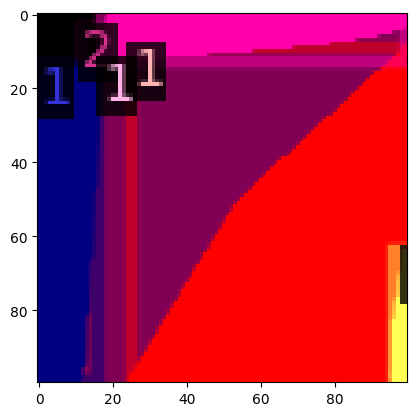

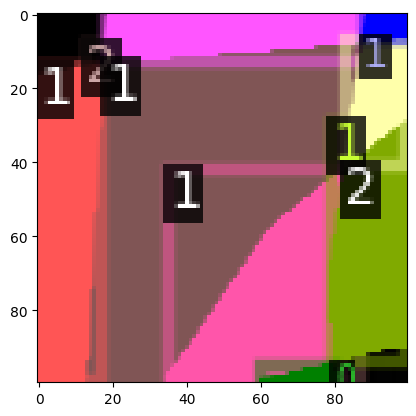

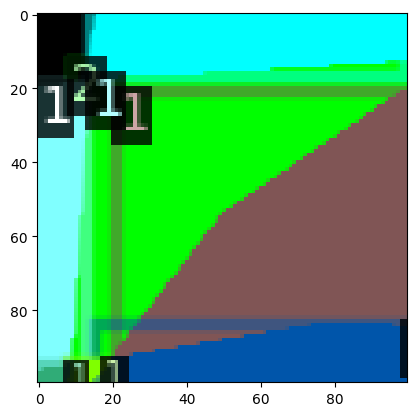

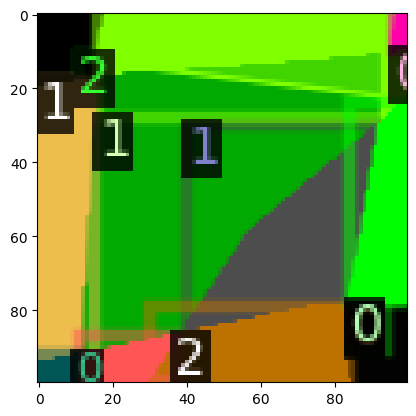

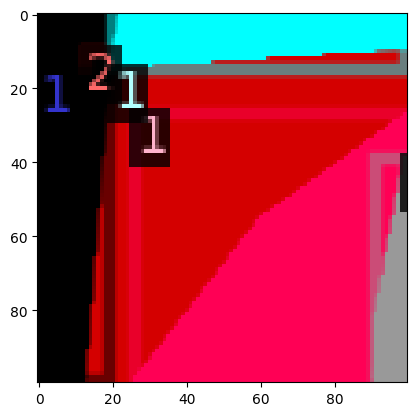

In [38]:
dataset_dicts = get_csd_dicts("csd/train")
# print(dataset_dicts)
from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [39]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cpu"
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/02 11:07:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[06/02 11:07:03 d2.engine.train_loop]: Starting training from iteration 0
[06/02 11:11:07 d2.utils.events]:  eta: 0:55:52  iter: 19  total_loss: 4.922  loss_cls: 1.453  loss_box_reg: 0.9551  loss_mask: 0.6895  loss_rpn_cls: 1.719  loss_rpn_loc: 0.1655    time: 11.9717  last_time: 11.1336  data_time: 0.1442  last_data_time: 0.0440   lr: 1.6068e-05  
[06/02 11:15:10 d2.utils.events]:  eta: 0:52:45  iter: 39  total_loss: 3.825  loss_cls: 0.9836  loss_box_reg: 0.9726  loss_mask: 0.6796  loss_rpn_cls: 0.9307  loss_rpn_loc: 0.1361    time: 12.0591  last_time: 12.3167  data_time: 0.0462  last_data_time: 0.0542   lr: 3.2718e-05  
[06/02 11:19:08 d2.utils.events]:  eta: 0:48:51  iter: 59  total_loss: 2.971  loss_cls: 0.7374  loss_box_reg: 0.9738  loss_mask: 0.6683  loss_rpn_cls: 0.484  loss_rpn_loc: 0.1228    time: 12.0046  last_time: 12.2622  data_time: 0.0446  last_data_time: 0.0470   lr: 4.9367e-05  
[06/02 11:23:18 d2.utils.events]:  eta: 0:45:08  iter: 79  total_loss: 2.738  loss_cls: 0.68

In [63]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/02 12:18:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[Checkpointer] Loading from ./output/model_final.pth ...


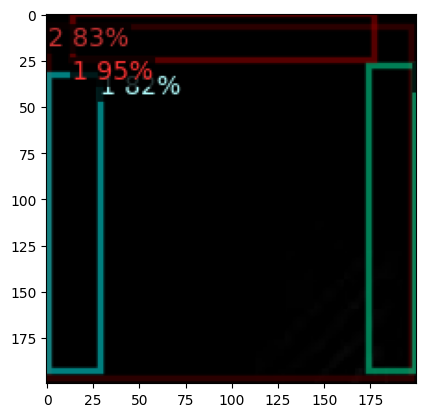

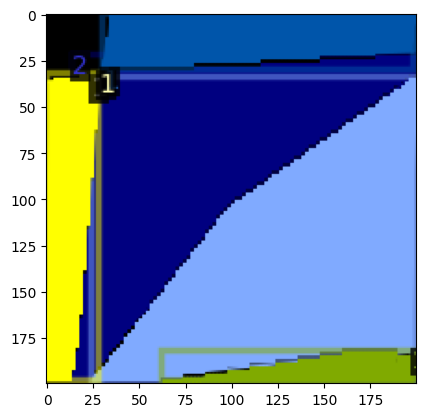

In [64]:

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_csd_dicts("csd/val")
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_metadata, 
                   scale=2,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_metadata, scale=2)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


In [114]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("csd_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "csd_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/02 03:33:35 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[06/02 03:33:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/02 03:33:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/02 03:33:35 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[06/02 03:33:35 d2.data.common]: Serialized dataset takes 0.34 MiB
[06/02 03:33:35 d2.evaluation.evaluator]: Start inference on 2 batches
[06/02 03:33:44 d2.evaluation.evaluator]: Inference done 1/2. Dataloading: 0.6554 s/iter. Inference: 7.7666 s/iter. Eval: 0.0015 s/iter. Total: 8.4263 s/iter. ETA=0:00:08
[06/02 03:33:50 d2.evaluation.evaluator]: Inference done 2/2. Dataloading: 0.0000 s/iter. Inference: 6.3783 s/iter. Eval: 0.0009 s/iter. Total: 6.3792 s/iter. ETA=0:00:00
[06/02 

AssertionError: ignored